# Histogram
Opracowanie: A.Florkowska

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.ndimage as nd
import scipy.misc
from scipy import ndimage
from skimage import io
from skimage import color
from skimage import exposure
from skimage import filters
import time
from IPython.display import Image

In [2]:
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
image = io.imread(".././images/example1.png")
image = image[:,:,0:3]
image = color.rgb2gray(image)
image = normalize(image)

# Histogram - definicja
Obraz jest macierzą pikseli / wokseli. Każdy piksel / woksel ma wartość, odpowiadającą jego intensywności. Histogram obrazu jest statystycznym opisem jego wartości, a więc przedstawia częstość wystąpień pikseli / wokseli danej intensywności na obrazie. 

Histogram zawiera przedziały (kosze), których wartość wskazuje na ilość wystąpień pikseli o intensywności określonej dla każdego przedziału. Użytkownik może sam dobrać liczbę przedziałów lub szerokość pojedynczego przedziału. Ma to bezpośredni wpływ na czytelność i przydatność histogramu do dalszej analizy obrazu.

Funkcja histogram z biblioteki Numpy jako argument przyjmuej obraz wejściowy i liczbę przedziałów, a zwraca dwie listy: liczby zliczeń oraz granice przedziałów. Histogram można wyświetlić w dwóch formach, jednak bardziej popularny i czytelny jest wykres słubkowy. Przed wyświetleniem należy jednak zmodyfikować listę argumentów: zamiast list wartości skrajnych przedziałów, musimy uzyskać listę wartości środka każdego przedziału.

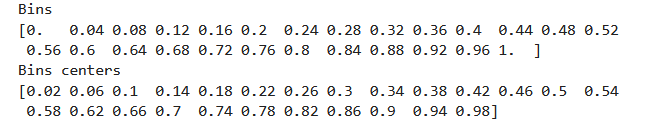

In [16]:
Image(filename=".././images/6_1.png", width=500)

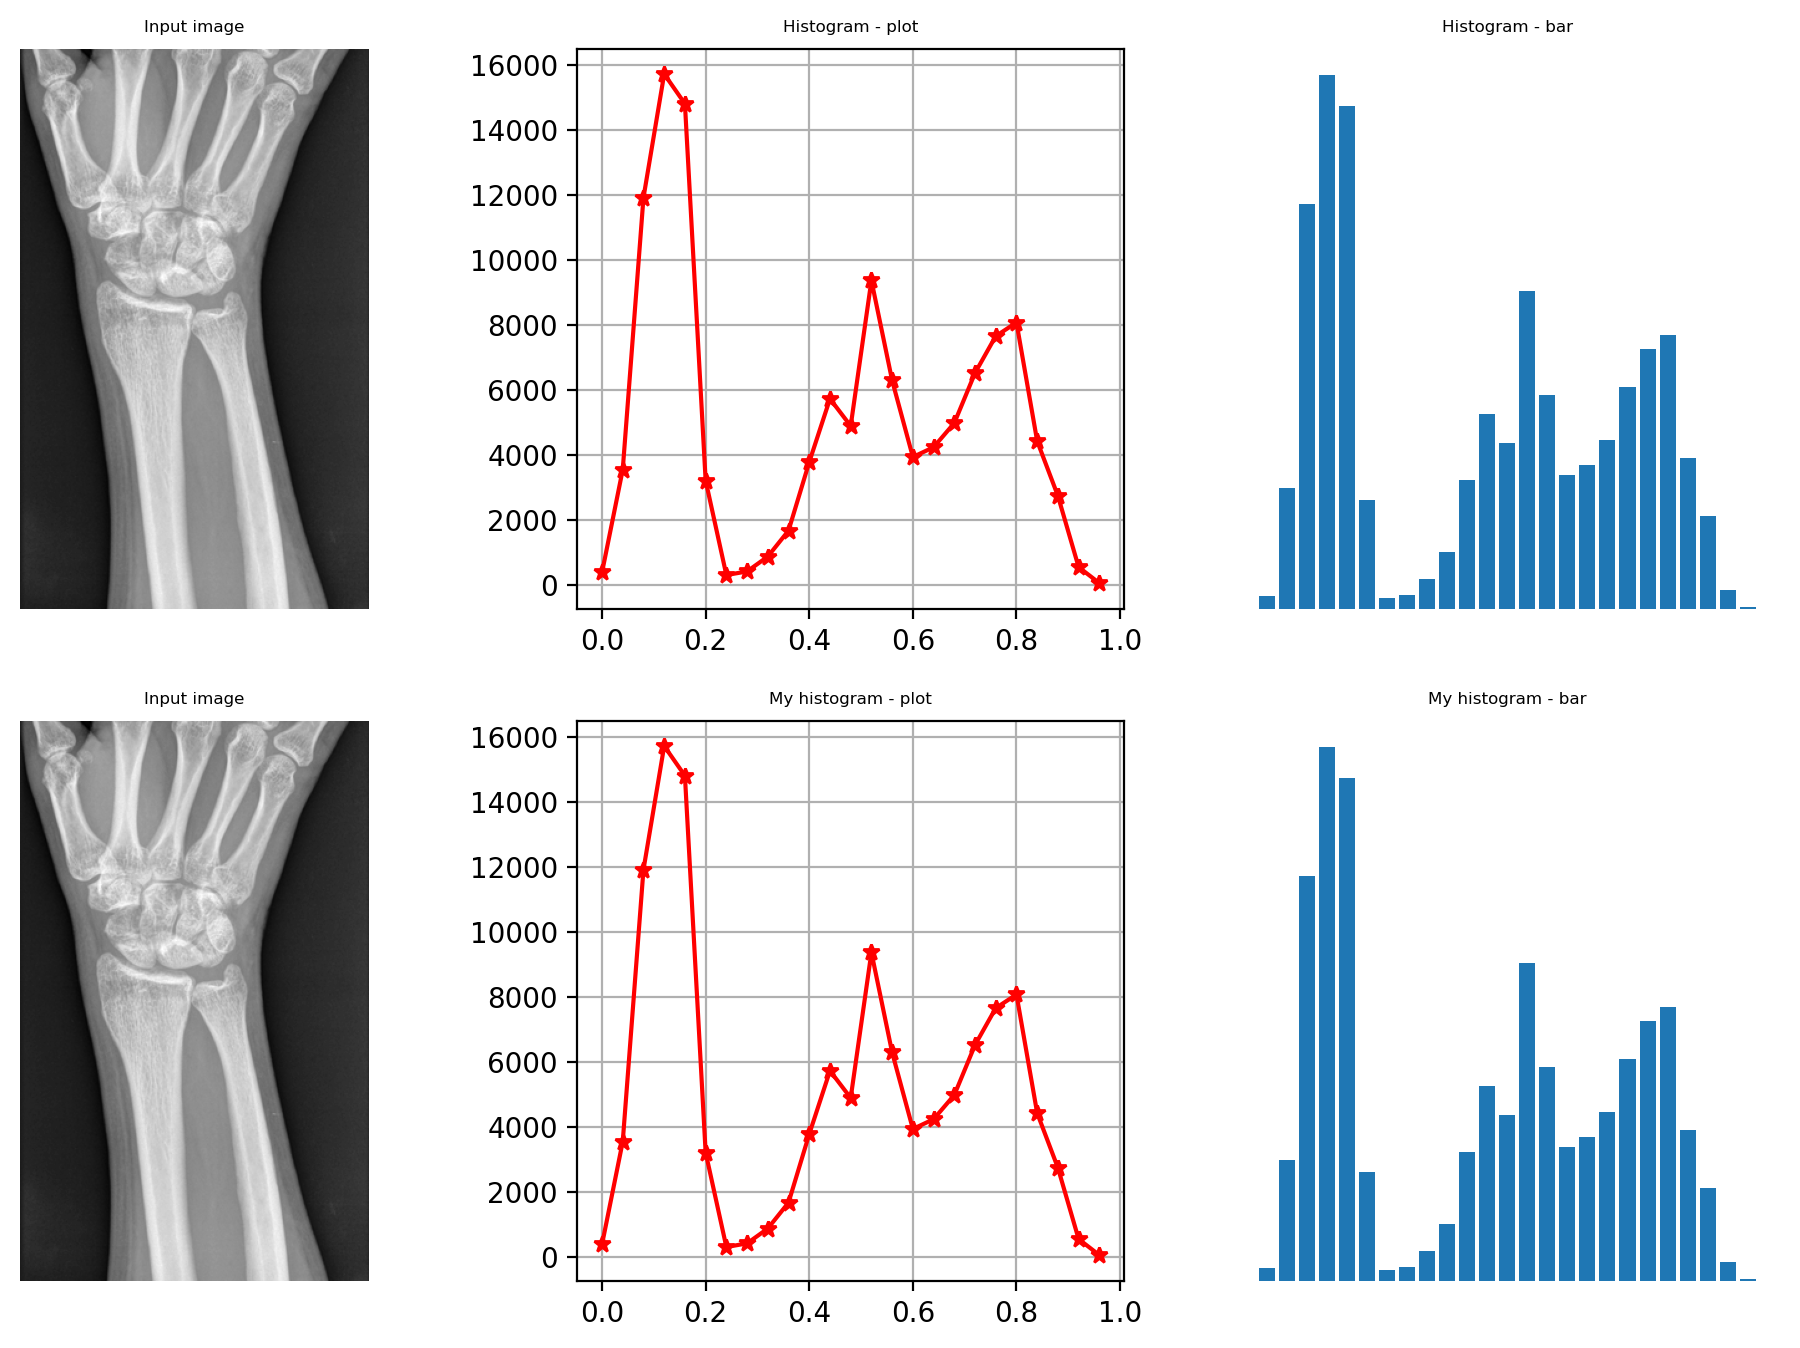

In [26]:
no_bins = 25
np_histogram, bins = np.histogram(image, bins=no_bins)
bins_centers = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.8

def my_histogram(image, bins_number):
    values_range = image.max() - image.min()
    single_bin = values_range / bins_number
    img_values , img_counts = np.unique(image.ravel(), return_counts=True)
    output_histogram = np.zeros(bins_number)
    output_bins = []
    
    condition = lambda x, low, upper : low <= x < upper
    for i in range(bins_number):
        first_val = image.min() + i * single_bin                   
        last_val = image.min() + (i+1) * single_bin
        indexies = [i for i, val in enumerate(img_values) if condition(val, first_val, last_val)]
        counts_for_selected_indexies = [img_counts[i] for i in indexies]  
        output_histogram[i] = np.sum(counts_for_selected_indexies)
        # It is possible to search 2d image to find elements that meet the condition
        # final_hist[i] = np.sum(img_counts[np.logical_and(img_values >= first_val, img_values < last_val)])
        output_bins.append(first_val)
        
    output_bins.append(last_val)
    output_bins = np.array(output_bins)
    return output_histogram, output_bins

my_histogram, my_bins = my_histogram(image, bins_number=no_bins)
my_bins_centers = (my_bins[:-1] + my_bins[1:]) / 2
my_width = (my_bins[1] - my_bins[0]) * 0.8

plt.figure(figsize=(12, 8), dpi=200)
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(2, 3, 2)
plt.plot(bins[:-1], np_histogram, "r*-")
plt.grid(True)
plt.title("Histogram - plot", fontsize=6)
plt.subplot(2, 3, 3)
plt.bar(bins_centers, np_histogram , width=width)
plt.axis('off')
plt.title("Histogram - bar", fontsize=6)
plt.subplot(2, 3, 4)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(2, 3, 5)
plt.plot(my_bins[:-1], my_histogram, "r*-")
plt.grid(True)
plt.title("My histogram - plot", fontsize=6)
plt.subplot(2, 3, 6)
plt.bar(my_bins_centers, my_histogram , width=width)
plt.axis('off')
plt.title("My histogram - bar", fontsize=6)
plt.show()

# Wyrównanie histogramu
To algorytm służący do tego, żeby rozkład wartości przyjmował cały zakres histogramu, czyli żeby uniknąć sytuacji, że piksele są skupione w jednym przedziale (binie). Takie działanie prowadzi do wyrównania poziomów szarości na obrazie, czyli poprawy kontrastu i ostrości. Rozkład histogramu staje się bardziej równomierny.

Składa się z poniższych kroków:
- konwersja obrazu 2D na sygnał 1D
- obliczenie histogramu obrazu (częstości wystąpień każdej z intensywności)
- obliczenie sumy skumulowanej (daje informację o tym, jaka część obrazu zawiera piksele o mniejszej intensywności, a jaka o większej)
- normalizacja
- zaokrąglenie wartości
- przypisanie zmodyfikowanych wartości w określone miejsca na obrazie: mapowanie
- konwersja sygnału 1D na obraz 2D

Polecam poniższy film wyjaśniający to zagadnienie, krok po kroku:
- https://www.youtube.com/watch?v=uqeOrtAzSyU

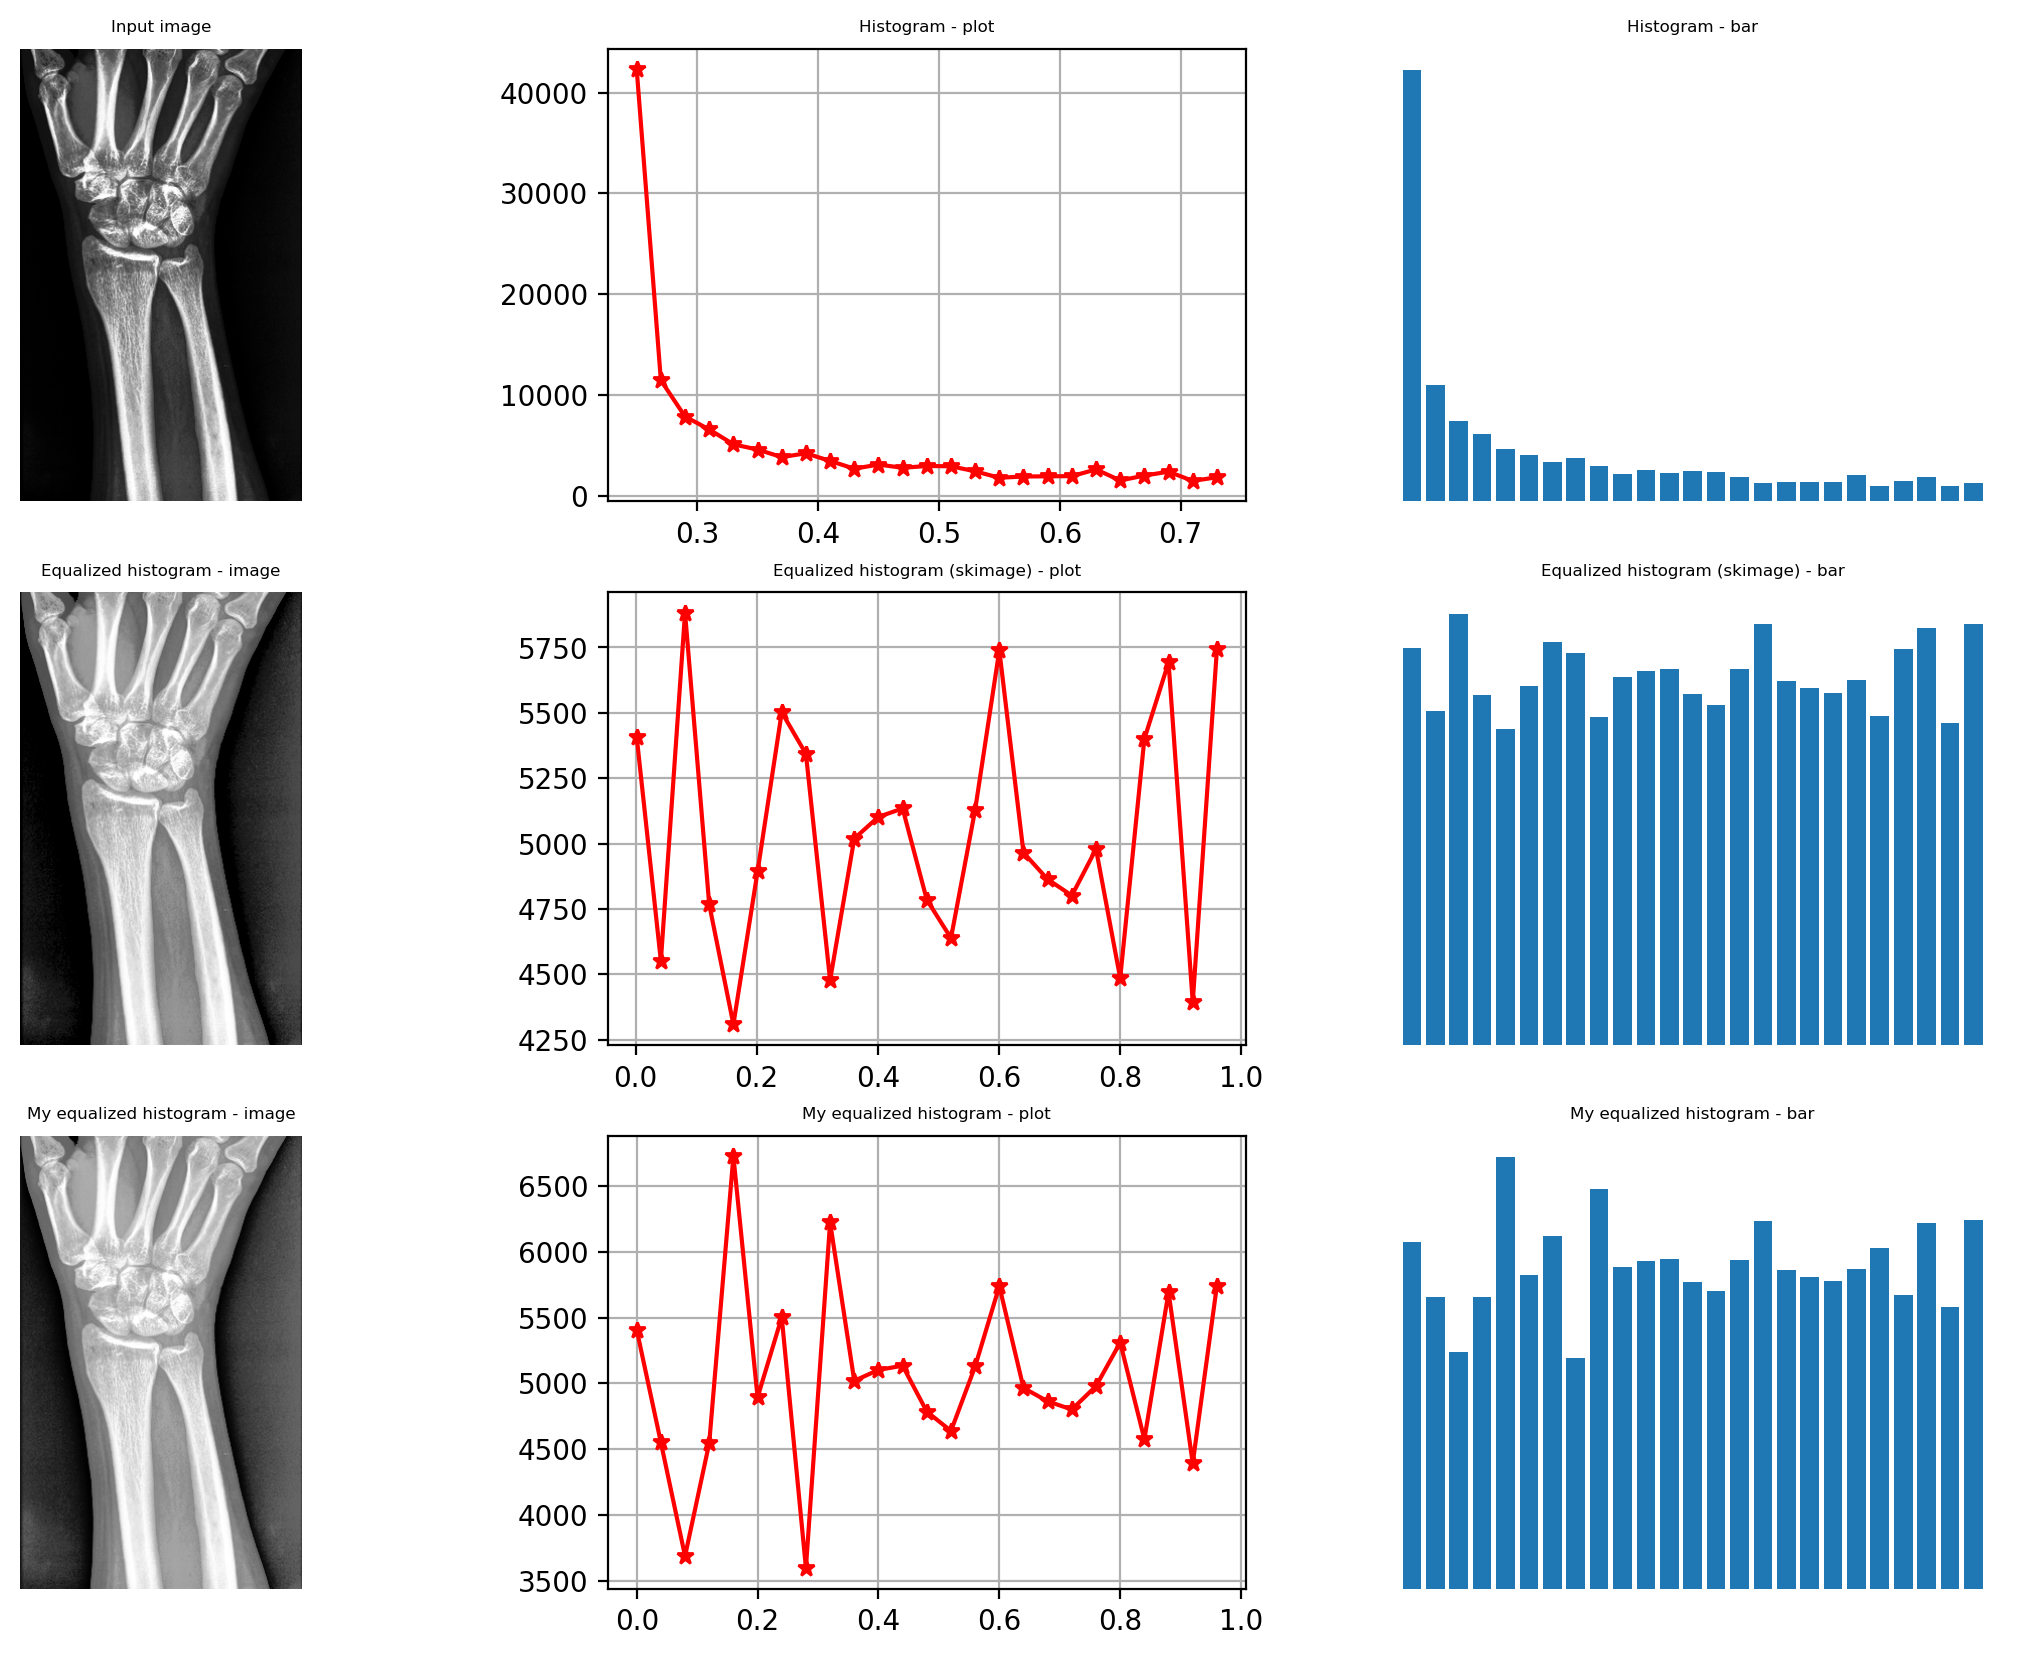

In [41]:
input_image = 0.5*image**3 + 0.25
def my_histogram_equalization(image):
    # CONVERSION: 2D to 1D
    # ravel() or flatten() methods. 
    # Ravel() method does not create a copy so modyfication of 1D array impacts also on original image. 
    # Flatten() method always creates a copy, but due to it, this method is less efficient.
    signal1D = image.ravel()
    # CALCULATING HISTOGRAM
    # hist_value - list of all, unique values
    # hist_index - list of indexes, whose each value of input array reffers to unique value array (hist_values)
    # hist_counts - list of the frequency of occurrences of each unique value
    #              Example: image.ravel() - [1,2,2,3,3,3]
    #                       hist_value [1,2,3]
    #                       hist_index = [0,1,1,2,2,2]
    hist_values, hist_index, hist_counts = np.unique(signal1D, return_counts=True, return_inverse=True)
    # CALCULATUNG CUMULATIVE DISTRIBUTION FUNCTION
    norm_values = np.cumsum(hist_counts).astype(np.float64)
    # NORMALIZATION TO RANGE [0,255]
    norm_values-= norm_values[0]
    norm_values/= (norm_values[-1] - norm_values[0])
    norm_values*= 255
    # ROUNDING TO INTEGER VALUES
    norm_values= np.round(norm_values)
    # MAPPING
    image_equalized = norm_values[hist_index]
    # CONVERSION: 1D to 2D
    image_equalized = np.reshape(image_equalized, image.shape)
    return image_equalized

no_bins = 25
np_histogram, bins = np.histogram(input_image, bins=no_bins)
bins_centers = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.8

img_my_eq_histogram = my_histogram_equalization(input_image)
img_my_eq_histogram = normalize(img_my_eq_histogram) # for the same x-axis scale
my_eq_histogram, my_eq_bins = np.histogram(img_my_eq_histogram, bins=no_bins)
my_eq_bins_centers = (my_eq_bins[:-1] + my_eq_bins[1:]) / 2
my_eg_width = (my_eq_bins[1] - my_eq_bins[0]) * 0.8

img_eq_histogram = exposure.equalize_hist(input_image)
eq_histogram, eq_bins = np.histogram(img_eq, bins=no_bins)
eq_bins_centers = (eq_bins[:-1] + eq_bins[1:]) / 2
eg_width = (eq_bins[1] - eq_bins[0]) * 0.8

plt.figure(figsize=(14, 10), dpi=200)
plt.subplot(3, 3, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(3, 3, 2)
plt.plot(bins[:-1], np_histogram, "r*-")
plt.grid(True)
plt.title("Histogram - plot", fontsize=6)
plt.subplot(3, 3, 3)
plt.bar(bins_centers, np_histogram , width=width)
plt.axis('off')
plt.title("Histogram - bar", fontsize=6)
plt.subplot(3, 3, 4)
plt.imshow(img_eq_histogram, cmap='gray')
plt.axis('off')
plt.title("Equalized histogram - image", fontsize=6)
plt.subplot(3, 3, 5)
plt.plot(eq_bins[:-1], eq_histogram, "r*-")
plt.grid(True)
plt.title("Equalized histogram (skimage) - plot", fontsize=6)
plt.subplot(3, 3, 6)
plt.bar(eq_bins_centers, eq_histogram , width=eg_width)
plt.axis('off')
plt.title("Equalized histogram (skimage) - bar", fontsize=6)
plt.subplot(3, 3, 7)
plt.imshow(img_my_eq_histogram, cmap='gray')
plt.axis('off')
plt.title("My equalized histogram - image", fontsize=6)
plt.subplot(3, 3, 8)
plt.plot(my_eq_bins[:-1], my_eq_histogram, "r*-")
plt.grid(True)
plt.title("My equalized histogram - plot", fontsize=6)
plt.subplot(3, 3, 9)
plt.bar(my_eq_bins_centers, my_eq_histogram , width=my_width)
plt.axis('off')
plt.title("My equalized histogram - bar", fontsize=6)
plt.show()


# Dopasowanie histogramu

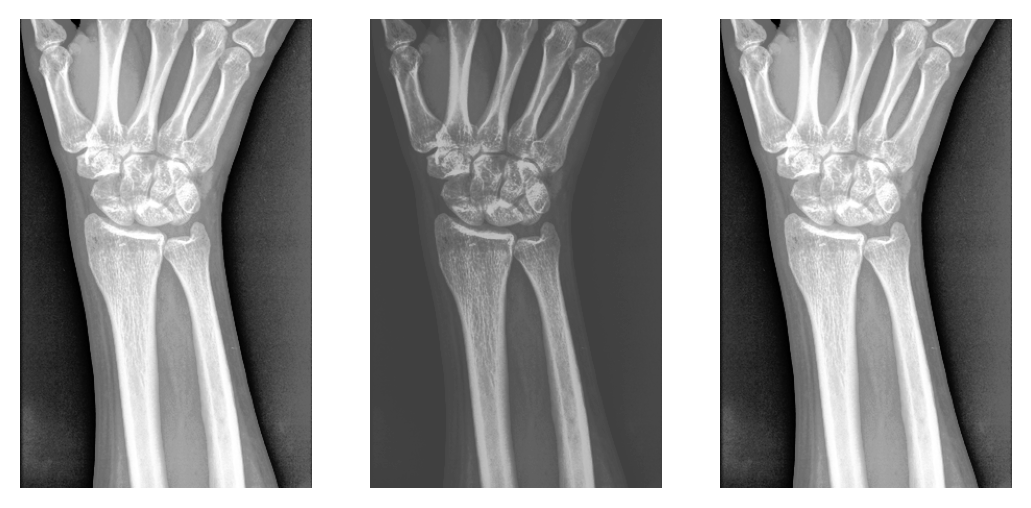

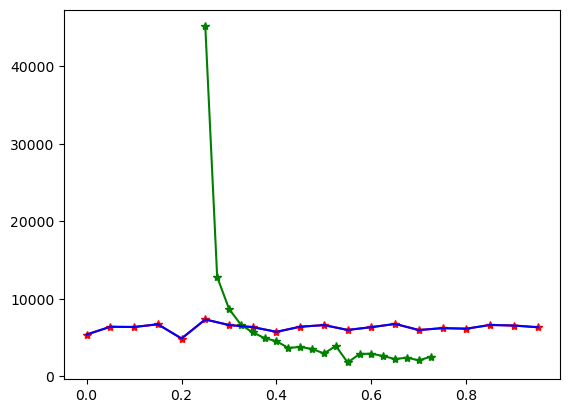

In [44]:
new_image = 0.5*image**3 + 0.25

normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image))

def histogram_matching(source, target): 
  source_values, source_bins, source_counts = np.unique(source, return_counts=True, return_inverse=True)
  target_values, target_counts = np.unique(target, return_counts=True)

  source_dist = np.cumsum(source_counts).astype(np.float64)
  target_dist = np.cumsum(target_counts).astype(np.float64)
  source_dist /= source_dist[-1]
  target_dist /= target_dist[-1]

  interp_values = np.interp(source_dist, target_dist, target_values)
 
  interp_values = interp_values[source_bins]
  source_matched = interp_values.reshape(source.shape)
  
  return source_matched
    
matched_image = normalize(new_image)
matched_image = histogram_matching(new_image, image)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(new_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(matched_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

no_bins = 20
hist, bins = np.histogram(image, no_bins)
new_hist, new_bins = np.histogram(new_image, no_bins)
matched_hist, matched_bins = np.histogram(matched_image, no_bins)


plt.figure(dpi=100)
plt.plot(bins[:-1], hist, "r*-")
plt.plot(new_bins[:-1], new_hist, "g*-")
plt.plot(matched_bins[:-1], matched_hist, "b,-")

plt.show()